# Raw Data Exploratory Data Analysis and Cleaning

This notebook assembles three raw EMI datasets and performs an initial exploration of the data.

Following the EDA, I'll prepare the data to be run through a random forest regression.

In [155]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import psycopg2
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

In [156]:
users = pd.read_csv('/Users/johnsnyder/GA-DSI-working/Capstone/EMI/users_clean.csv')

In [157]:
words = pd.read_csv('/Users/johnsnyder/GA-DSI-working/Capstone/EMI/words_categorized.csv')

In [158]:
users.describe()

,Unnamed: 0,RESPID,AGE,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,...,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
count,48645.000000,48645.000000,48178.000000,42706.000000,42820.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,...,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,42210.000000,48645.000000,35520.000000,35520.000000
mean,24322.000000,25562.400391,39.277180,0.926872,1.094979,49.113570,54.624422,51.284449,37.309125,34.585430,...,55.011029,58.636433,53.665898,46.962657,53.446437,39.664562,35.579258,53.826288,42.232447,41.362631
std,14042.746259,15033.356108,15.955373,0.809391,0.924138,27.545252,23.770780,26.487641,23.598351,23.234577,...,25.486398,23.837543,25.389724,26.664165,25.795551,26.061055,25.374290,25.891354,25.680349,26.455730
min,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12161.000000,12161.000000,NaN,NaN,NaN,28.000000,44.000000,31.000000,14.000000,12.000000,...,41.000000,48.000000,36.000000,28.000000,33.000000,13.000000,NaN,35.000000,NaN,NaN
50%,24322.000000,26605.000000,NaN,NaN,NaN,51.000000,53.000000,52.000000,34.000000,32.000000,...,53.000000,64.000000,54.000000,50.000000,53.000000,37.000000,NaN,56.000000,NaN,NaN
75%,36483.000000,38766.000000,NaN,NaN,NaN,70.000000,71.000000,71.000000,52.000000,51.000000,...,72.000000,73.000000,71.000000,68.000000,71.000000,56.000000,NaN,71.000000,NaN,NaN
max,48644.000000,50927.000000,94.000000,5.000000,5.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


## Basic respondent information
**Age** --
Mean age is 39.28 years. Youngest is 13, oldest is 94.

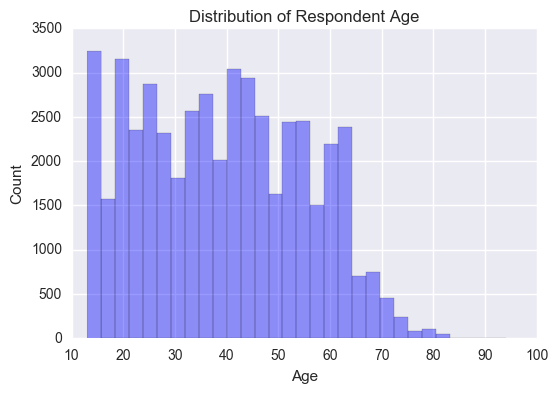

In [159]:
plt.title('Distribution of Respondent Age')
sns.distplot(users['AGE'].dropna(),bins=30, kde=False, color='b')
plt.xlabel('Age')
plt.ylabel('Count')

In [160]:
print "Male/Female breakdown:"
print "{}".format(users['GENDER'].value_counts())

Male/Female breakdown:
Female    24503
Male      24142
Name: GENDER, dtype: int64


## Bring in userkey for reference

In [161]:
userkey = pd.read_csv('/Users/johnsnyder/GA-DSI-working/Capstone/EMI/UserKey.csv',usecols=[0,1],header=None)

In [162]:
userkey

,0,1
0,RESPID,User id
1,GENDER,Male/Female
2,AGE,Age in years
3,WORKING,Working status
4,REGION,Region of the UK
5,MUSIC,Listening to music that you have chosen / boug...
6,LIST_OWN,Listening to music that may be on in the backg...
7,LIST_BACK,Listening to music that may be on in the backg...
8,Q1,I enjoy actively searching for and discovering...
9,Q2,I find it easy to find new music (Thinking now...


# A note on biases in survey responses

A phenomenon that repeatedly shows up in this data is the "peakiness" of respondents' answers. In large part, I attribute this to the fact that responses were given on a scale of 0-100, and many respondents will subconsciously (or perhaps consciously?) generalize their sentiments around values of 10, 30, 50, 70, and 90. For example, if we look at all responses to the questionnaire in the user survey, we see peaks along these values, with another peak at 100.

In other words, if I think something is "pretty good" on a scale of 0-100, I'll probably give it a rating of 70 instead of 76 or 81.

We can see the same phenomenon in the distribution of rating scores as well, below. This will provide an interesting challenge in modeling.

In [163]:
user_histplot = users.loc[:,['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10',
                             'Q11','Q12','Q13','Q14','Q15','Q16','Q17','Q18','Q19']]

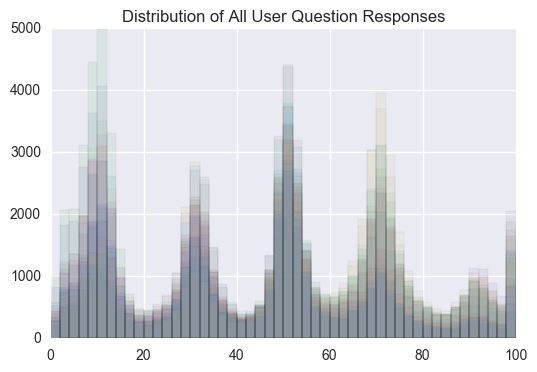

In [164]:
for i in user_histplot:
    users[i].hist(bins=50,alpha=0.1)
    
plt.title('Distribution of All User Question Responses')

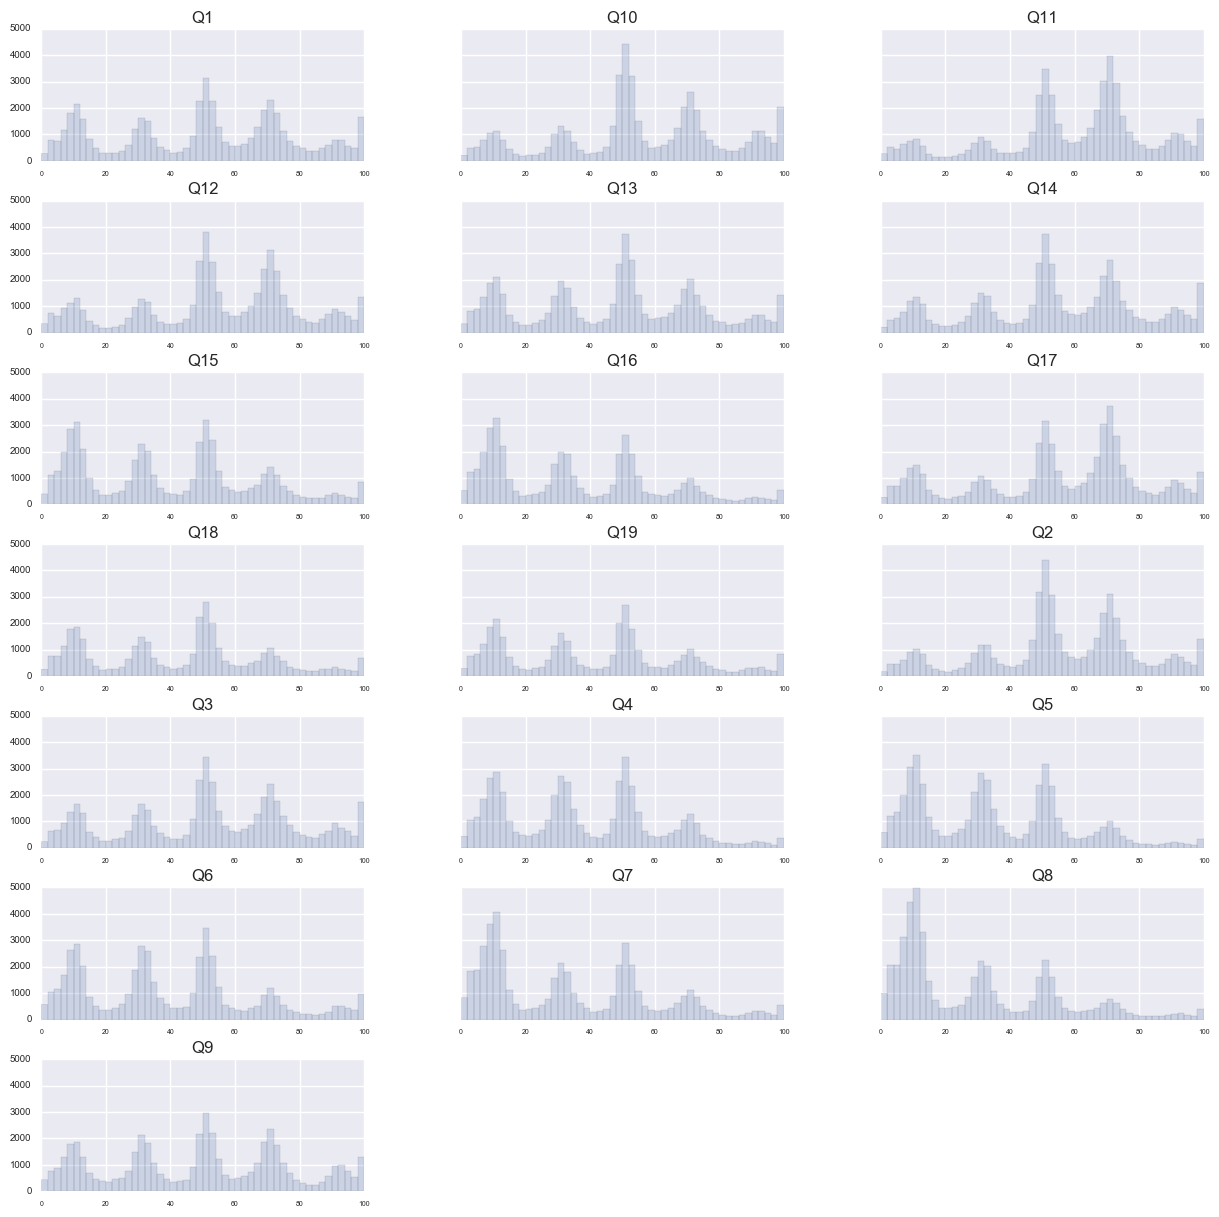

In [165]:
user_histplot.hist(xlabelsize=5,ylabelsize=7,bins=50, layout=(7,3),figsize=(15,15),sharey=True,alpha=0.2);


In [166]:
# Bring in train dataset
train = pd.read_csv('/Users/johnsnyder/GA-DSI-working/Capstone/EMI/train.csv')

#### As noted above, song ratings are distributed around peaks at 10, 30, 50, 70, 90, and 100.

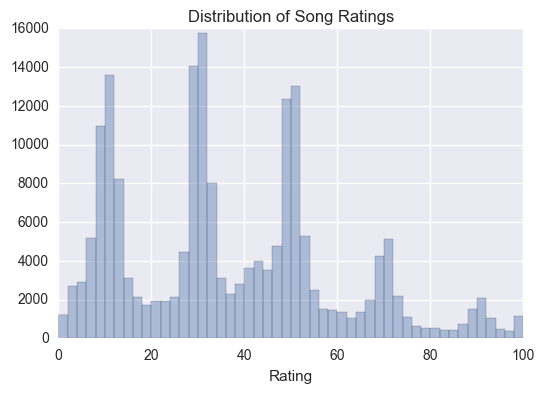

In [167]:
sns.distplot(train['Rating'],kde=False)
plt.title('Distribution of Song Ratings')

### Distribution of median track ratings for artists

The graph below plots the distribution of median track ratings for each artist. First and foremost, it's pretty clear that most listeners are not showing lots of love for any particular artist. If we are judging popularity by median track rating, the most "popular" artist is only getting slightly over a 5/10 score.

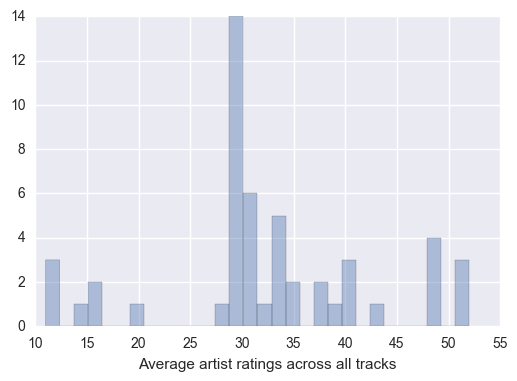

In [168]:
sns.distplot(pd.pivot_table(train, index='Artist',values=['Rating'], aggfunc='median')
             , kde=False, bins=30, axlabel='Average artist ratings across all tracks')

### Distribution of track ratings

Looking at the median value of ratings of tracks, we see that listeners tend to give poor-to-average ratings for most tracks, at ratings of 30-35. This peak is similar for median ratings for artists. There are only two songs that are on average rated above 60, and there is a surprising little cluster of songs rated below 20 (ouch).

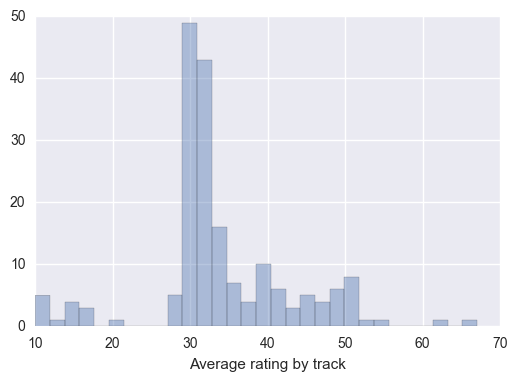

In [169]:
track_ratings = pd.pivot_table(train, index='Track',values=['Rating'], aggfunc='median')
sns.distplot(track_ratings, kde=False, bins=30, axlabel='Average rating by track')

### Comparing distributions of mean and median artist ratings

By comparing the mean and median ratings of artists across their tracks, we see that mean artist ratings are peaked further to the right than median artist ratings. All tracks have ratings lower than 5 and greater than 90, so it is likely that some artists have tracks with some very high track ratings that pull the mean distribution rightward from the median.

Below the median/mean distributions plot is a plot of the frequency of track ratings above 80 and below 20. More artist tracks are commonly rated poorly than positively.

In [170]:
artists_mean = pd.pivot_table(train, index='Artist',values=['Rating'])
artists_median = pd.pivot_table(train, index='Artist',values=['Rating'],aggfunc=np.median)
scores = [artists_mean, artists_median]

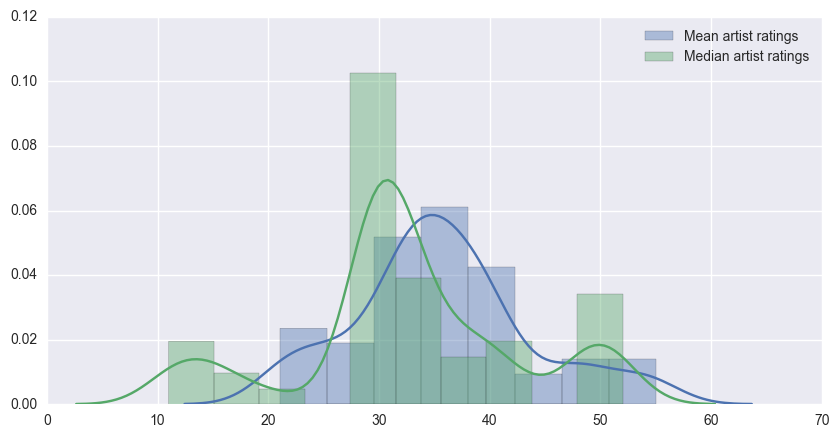

In [171]:
plt.figure(figsize=(10,5))
for i in scores:
    sns.distplot(i)

plt.legend(['Mean artist ratings','Median artist ratings'])

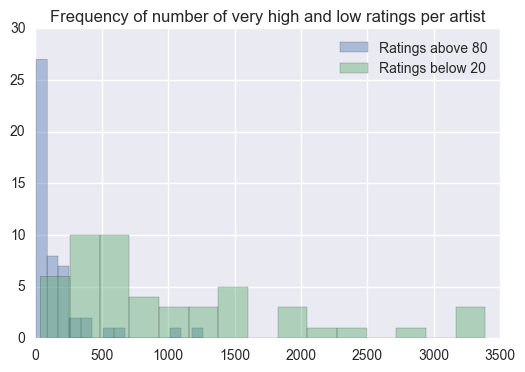

In [172]:
sns.distplot(pd.pivot_table(train[train['Rating']>80], index='Artist',values=['Rating'], 
                            aggfunc='count'), kde=False, bins= 15)
sns.distplot(pd.pivot_table(train[train['Rating']<20], index='Artist',values=['Rating'], 
                            aggfunc='count'), kde=False, bins= 15)
plt.title('Frequency of number of very high and low ratings per artist')
plt.legend(['Ratings above 80', 'Ratings below 20'])



# Data Cleaning!

### Clean Region category

There is a duplicate category in the Region feature of the dataset. After consulting with the UK contingent of our class, I'll combine North Ireland and Northern Ireland together.

In [173]:
users['REGION'].unique()

array(['South', 'Midlands', 'North', 'Centre', nan, 'Northern Ireland',
       'North Ireland'], dtype=object)

In [174]:
def region_cleaner(x):
    if x == 'North Ireland':
        return 'Northern Ireland'
    else:
        return x

In [175]:
users['REGION'] = users['REGION'].apply(region_cleaner)

In [176]:
users['REGION'].unique()

array(['South', 'Midlands', 'North', 'Centre', nan, 'Northern Ireland'], dtype=object)

In [177]:
pd.pivot_table(users, index='REGION', values=['AGE'])

,AGE
REGION,
Centre,39.948709
Midlands,39.636433
North,39.281763
Northern Ireland,38.789062
South,38.817181


#### Visualize null values in Users dataset

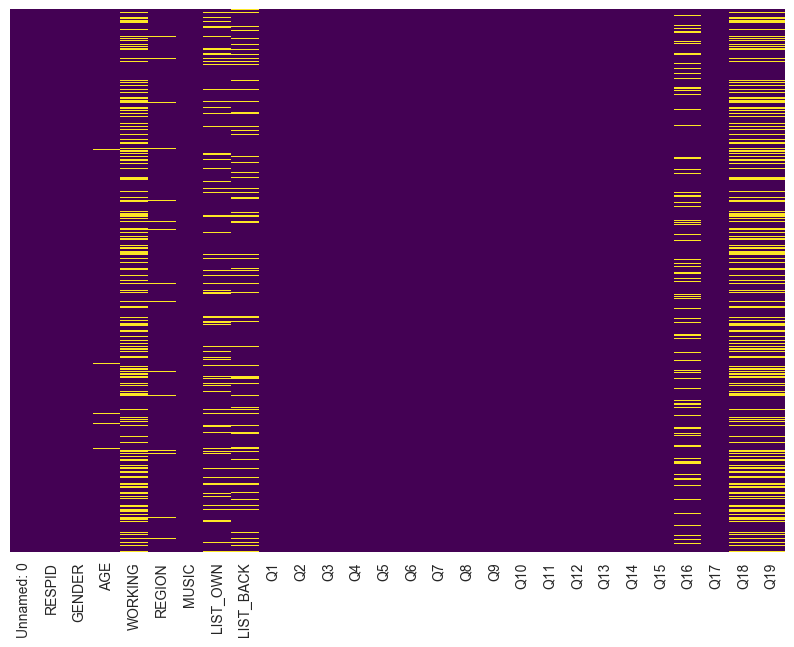

In [178]:
plt.figure(figsize=(10,7))
sns.heatmap(users.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [179]:
# It appears that if users do not answer Question 18, they also do not answer Question 19.
print 'Q18=Q19? - {}'.format(len(users['Q19'])-sum(pd.isnull(users['Q19']))==\
                             len(users['Q18'])-sum(pd.isnull(users['Q18'])))
print 'Missing values: {}'.format(len(users['Q19'])-sum(pd.isnull(users['Q19'])))

Q18=Q19? - True
Missing values: 35520


In [180]:
print 'Length of training dataset: {}'.format(len(train))
print 'Length of users dataset: {}'.format(len(users))
print 'Length of words dataset: {}'.format(len(words))


Length of training dataset: 188690
Length of users dataset: 48645
Length of words dataset: 118301


# Creating database connection and moving csv files to SQL for a quick query

While joining the three datasets could be done in pandas, I'd like to use a little SQL for old time's sake.

In [181]:
train_sql = train
userkey_sql = userkey
users_sql = users
words_sql = words

In [182]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://johnsnyder@localhost:5432/EMI', client_encoding='Latin1')
engine.text_factory = str
train_sql.to_sql("train", engine, if_exists='replace')
words_sql.to_sql("words", engine, if_exists='replace')
userkey_sql.to_sql("userkey", engine, if_exists='replace')
users_sql.to_sql("users", engine, if_exists='replace')


The following query combines all three tables into one. I'll then pull the table back into pandas for further revising.

In [183]:
data = pd.read_sql('SELECT * FROM train LEFT JOIN words ON train."User" \
                    = words."User" and train."Artist" = words."Artist"\
                    LEFT JOIN users ON train."User" = users."RESPID"', engine)
data.head()

,index,Artist,Track,User,Rating,Time,index,Unnamed: 0,Artist,User,...,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
0,163270,1,5,3566,41,18,58971.0,58971.0,1.0,3566.0,...,12.0,65.0,65.0,80.0,79.0,51.0,31.0,68.0,54.0,33.0
1,159391,3,9,3566,16,18,98848.0,98848.0,3.0,3566.0,...,12.0,65.0,65.0,80.0,79.0,51.0,31.0,68.0,54.0,33.0
2,144298,1,4,3566,44,18,58971.0,58971.0,1.0,3566.0,...,12.0,65.0,65.0,80.0,79.0,51.0,31.0,68.0,54.0,33.0
3,74698,4,11,3566,71,18,19311.0,19311.0,4.0,3566.0,...,12.0,65.0,65.0,80.0,79.0,51.0,31.0,68.0,54.0,33.0
4,173934,14,32,11495,42,19,13173.0,13173.0,14.0,11495.0,...,3.0,63.0,50.0,49.0,58.0,33.0,28.0,62.0,30.0,7.0


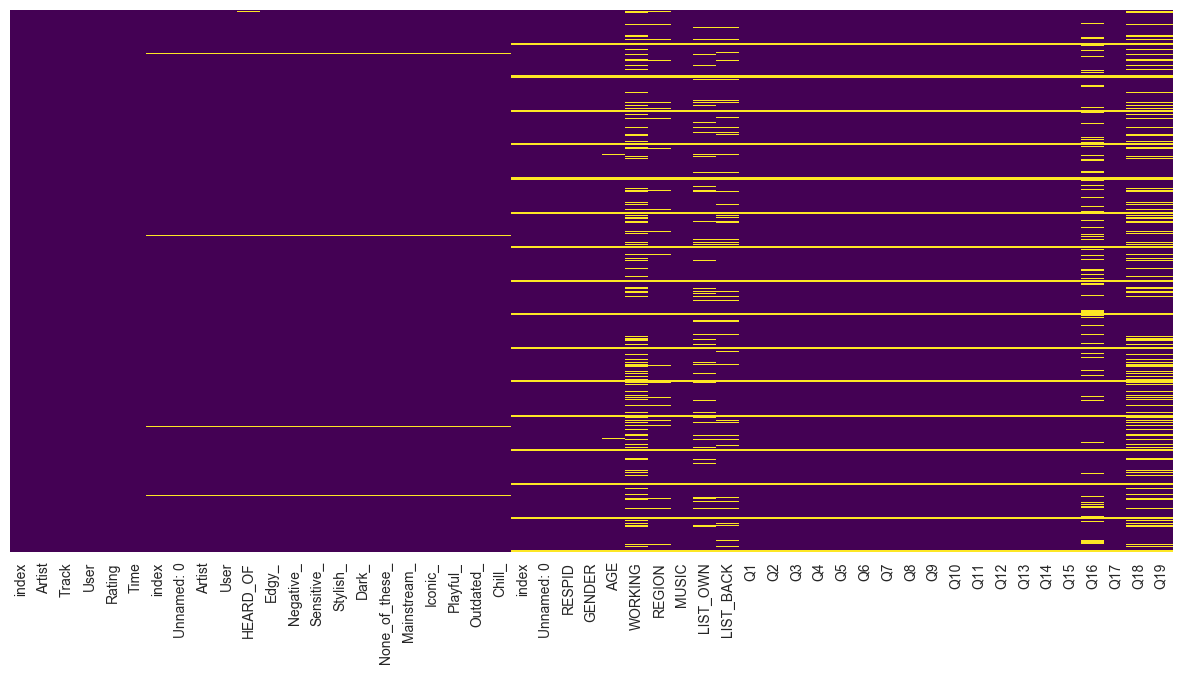

In [184]:
# Visualizing null values in the dataset
plt.figure(figsize=(15,7))
sns.heatmap(data.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [185]:
data.shape

(188690, 51)

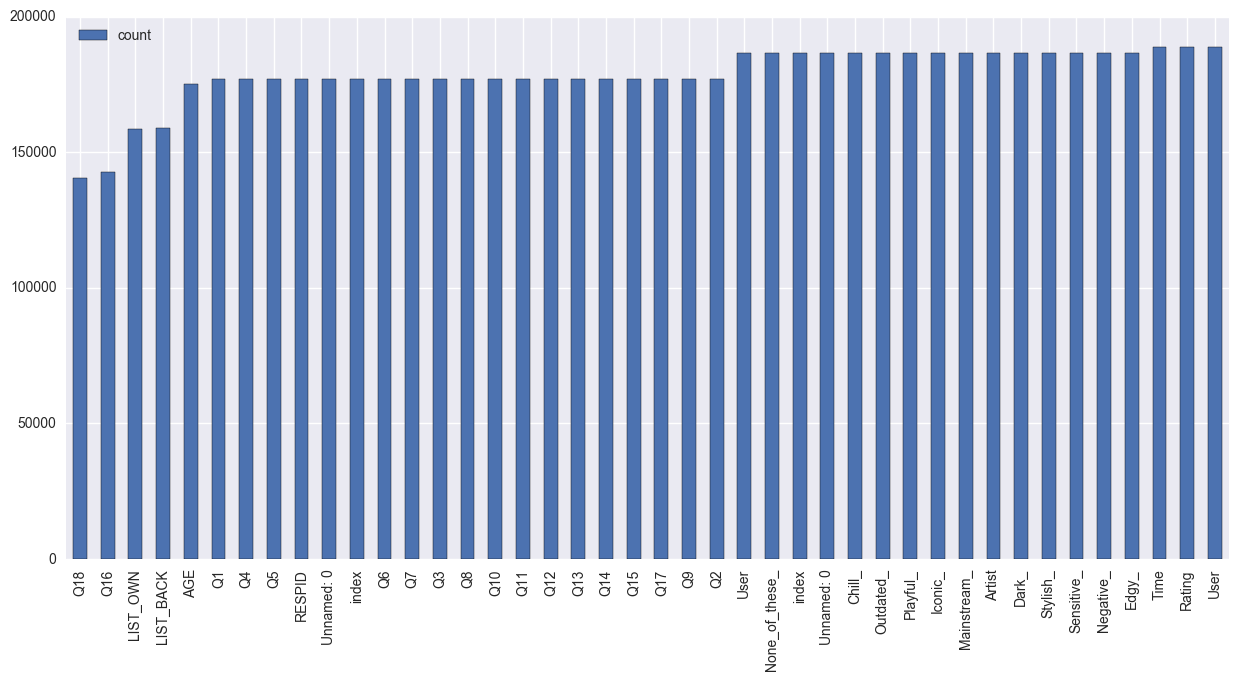

In [186]:
# Plot the counts of non-null values in the dataset
data_counts = data.describe()
data_counts = data_counts.iloc[0:1,3:]
data_counts = data_counts.T.sort_values('count')
data_counts = data_counts.iloc[1:,:]
data_counts.plot(kind='bar', figsize=(15,7))

#### Because Q18 and Q19 have nearly 50,000 missing data points (see below - we know that when Q18 is null, Q19 is also null), I'm going to drop these features for the sake of retaining as many data points as possible. If my model is weak, I'll return to this section and add these features back in.

In [187]:
data[data['Q18'].isnull()==True].shape

(48145, 51)

#### Interestingly enough, the same number of users who fail to report their working status also fail to report an answer to Q18, so dropping Q18 and Q19 won't help us if the 'WORKING' column remains in the dataset untouched.

In [188]:
print users[users['WORKING'].isnull()==True].shape
print users[users['Q18'].isnull()==True].shape

(13125, 28)
(13125, 28)


In [189]:
data[data['WORKING'].isnull()==True].shape

(48145, 51)

In [190]:
# Drop any columns that do not have more than 100,000 non-null values
data_drop = data.dropna(axis=1,thresh=100000)

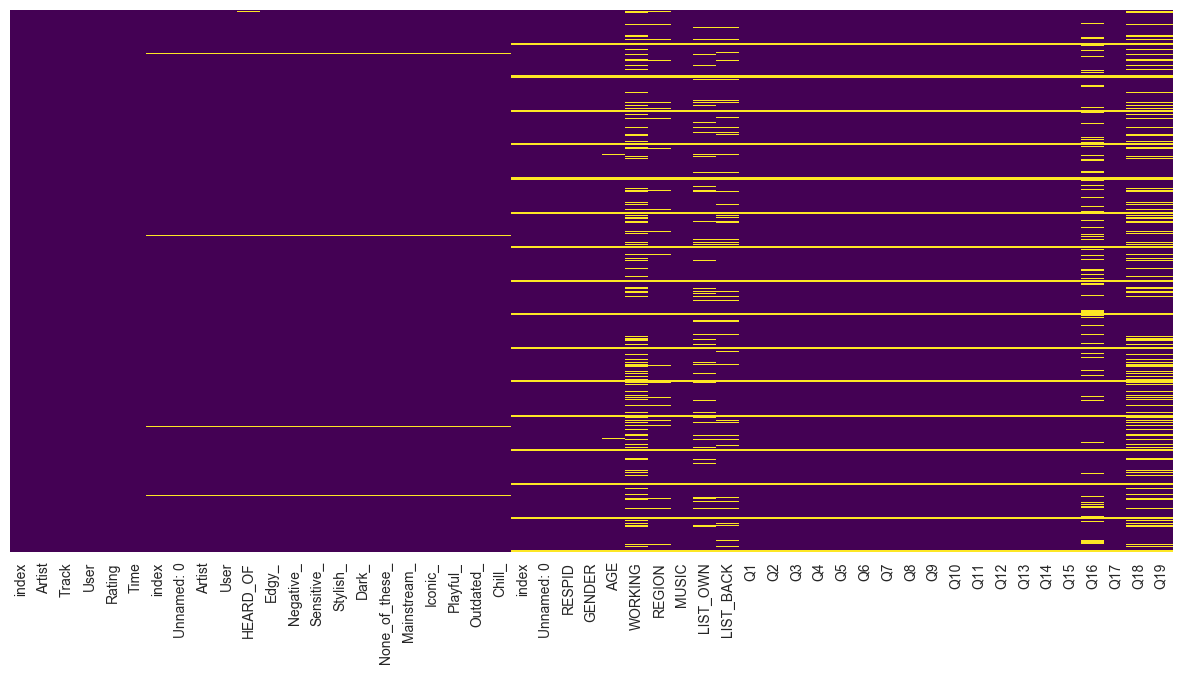

In [191]:
plt.figure(figsize=(15,7))
sns.heatmap(data_drop.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [192]:
data_drop = data_drop.drop(['Unnamed: 0'], axis=1)
data_drop = data_drop.drop(['RESPID'], axis=1)
data_drop = data_drop.drop(['Q18'], axis=1)
data_drop = data_drop.drop(['Q19'], axis=1)
data_drop = data_drop.drop(['WORKING'], axis=1)

In [193]:
data_drop.shape

(188690, 45)

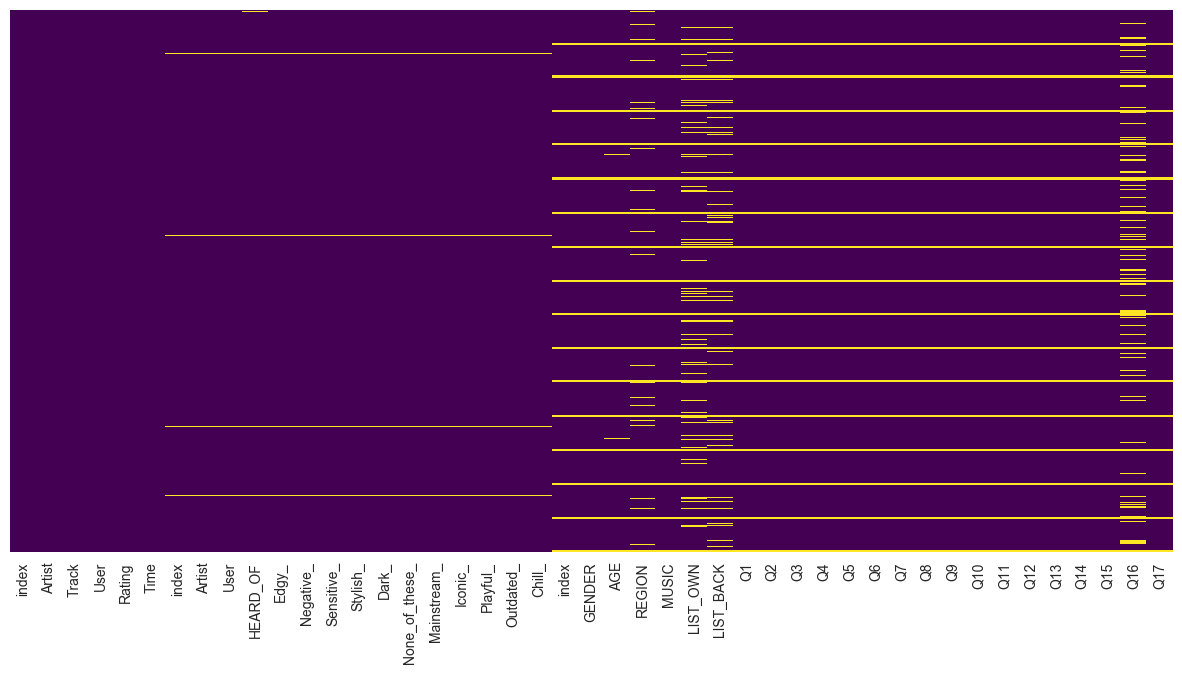

In [194]:
plt.figure(figsize=(15,7))
sns.heatmap(data_drop.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [220]:
data_clean = data_drop.dropna()

In [221]:
data_clean.shape

(111460, 45)

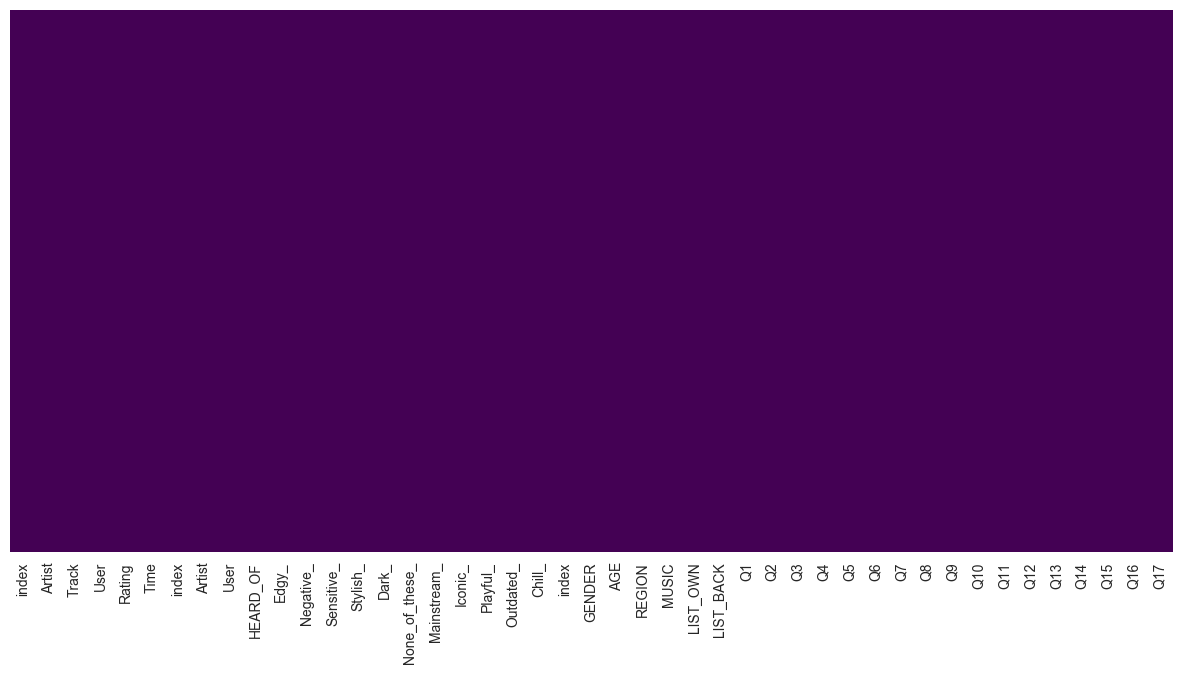

In [222]:
plt.figure(figsize=(15,7))
sns.heatmap(data_clean.isnull(),yticklabels=False, cbar=False, cmap='viridis')

## Create dummy variables, normalize data


In [223]:
data_clean.columns

Index([u'index', u'Artist', u'Track', u'User', u'Rating', u'Time', u'index',
       u'Artist', u'User', u'HEARD_OF', u'Edgy_', u'Negative_', u'Sensitive_',
       u'Stylish_', u'Dark_', u'None_of_these_', u'Mainstream_', u'Iconic_',
       u'Playful_', u'Outdated_', u'Chill_', u'index', u'GENDER', u'AGE',
       u'REGION', u'MUSIC', u'LIST_OWN', u'LIST_BACK', u'Q1', u'Q2', u'Q3',
       u'Q4', u'Q5', u'Q6', u'Q7', u'Q8', u'Q9', u'Q10', u'Q11', u'Q12',
       u'Q13', u'Q14', u'Q15', u'Q16', u'Q17'],
      dtype='object')

In [224]:
dummy_cols = ['GENDER','REGION','MUSIC', 'HEARD_OF', 'LIST_OWN', 'LIST_BACK']
for i in dummy_cols:
    data_clean = pd.concat([data_clean, pd.get_dummies(data_clean[i], drop_first=True, prefix=i)],axis=1)
    data_clean = data_clean.drop(i,axis=1)


In [225]:
data_clean.columns

Index([                                                            u'index',
                                                                  u'Artist',
                                                                   u'Track',
                                                                    u'User',
                                                                  u'Rating',
                                                                    u'Time',
                                                                   u'index',
                                                                  u'Artist',
                                                                    u'User',
                                                                   u'Edgy_',
                                                               u'Negative_',
                                                              u'Sensitive_',
                                                                u'Stylish_',

In [226]:
# Remove duplicate columns and reorganize
data_clean['Artist_ID'] = data_clean.iloc[:,7]
data_clean['Index'] = data_clean.iloc[:,0]
data_clean['User_ID'] = data_clean.iloc[:,8]
data_clean = data_clean.drop(['Artist', 'index', 'User'], axis=1)
cols = data_clean.columns.tolist()
cols = cols[-3:] + cols[:-3]
data_clean = data_clean.ix[:,cols]


In [227]:
header_cols = ['Artist_ID', 'Index', 'User_ID', 'Track', 'Time', 'Rating']
new_cols = header_cols + cols[6:]
data_clean = data_clean.ix[:,new_cols]
data_clean.head()

,Artist_ID,Index,User_ID,Track,Time,Rating,Edgy_,Negative_,Sensitive_,Stylish_,...,LIST_OWN_1.0,LIST_OWN_2.0,LIST_OWN_3.0,LIST_OWN_4.0,LIST_OWN_5.0,LIST_BACK_1.0,LIST_BACK_2.0,LIST_BACK_3.0,LIST_BACK_4.0,LIST_BACK_5.0
0,1.0,163270,3566.0,5,18,41,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.0,159391,3566.0,9,18,16,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,144298,3566.0,4,18,44,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,74698,3566.0,11,18,71,1.0,0.0,1.0,3.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,14.0,173934,11495.0,32,19,42,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


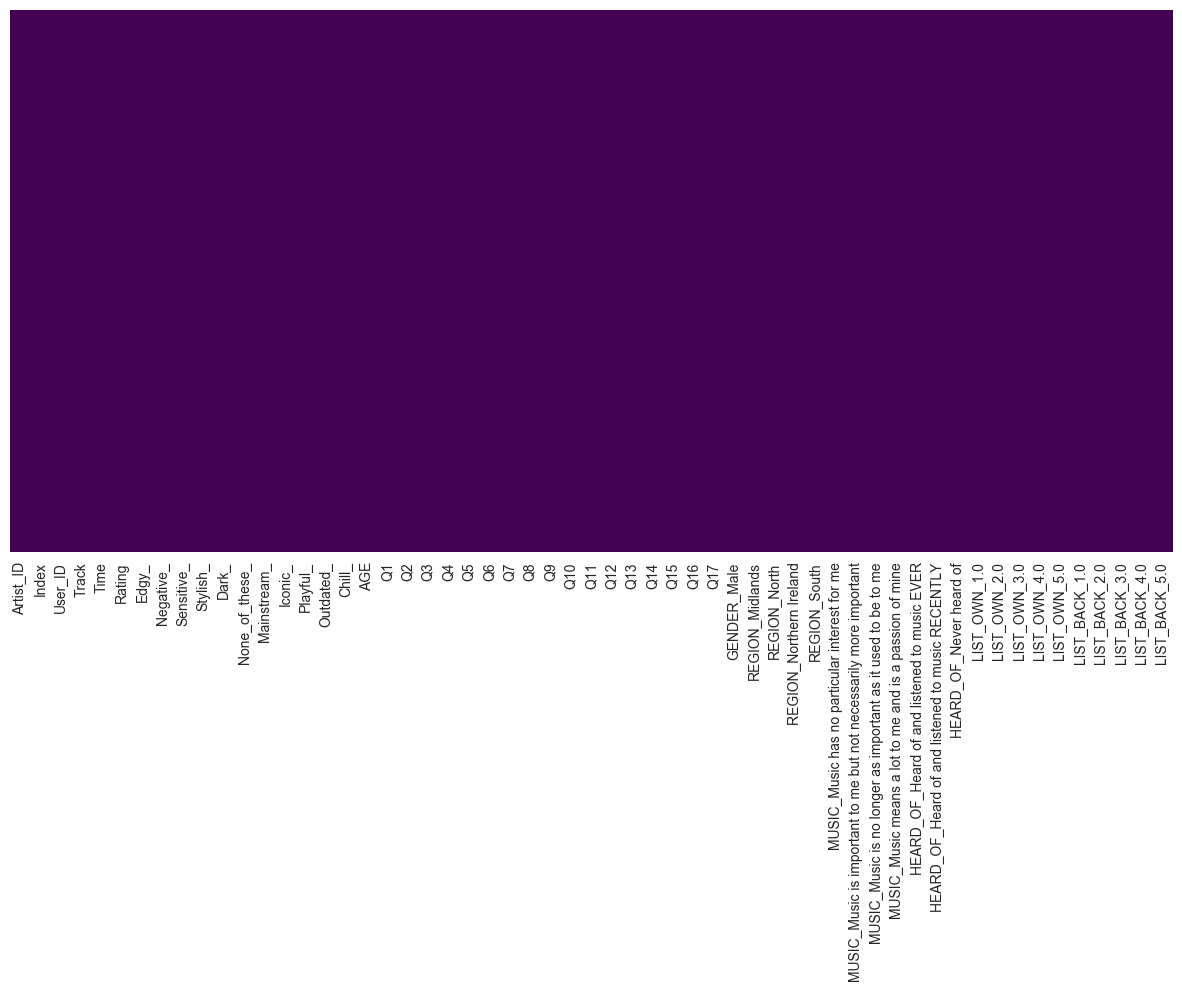

In [228]:
plt.figure(figsize=(15,7))
sns.heatmap(data_clean.isnull(),yticklabels=False, cbar=False, cmap='viridis')

When I categorized the Words dataset (a list of adjectives for how artists sound), I added up each time a 1 was provided for each of the words in the list. In my words_cleaner function, I say that categories with sums of 1 or higher should be marked solely by a 1, while catories with sums of zero remain to be zero. While this approach is intented to prevent inadvertent overweighting from grouping words together, it may also ultimately underweight user responses. In another notebook, I will test out another approach.

In [229]:
def words_cleaner(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return None


In [232]:
data_clean.iloc[:,6:17] = data_clean.iloc[:,6:17].applymap(words_cleaner)
data_clean.head()

,Artist_ID,Index,User_ID,Track,Time,Rating,Edgy_,Negative_,Sensitive_,Stylish_,...,LIST_OWN_1.0,LIST_OWN_2.0,LIST_OWN_3.0,LIST_OWN_4.0,LIST_OWN_5.0,LIST_BACK_1.0,LIST_BACK_2.0,LIST_BACK_3.0,LIST_BACK_4.0,LIST_BACK_5.0
0,1.0,163270,3566.0,5,18,41,0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.0,159391,3566.0,9,18,16,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,144298,3566.0,4,18,44,0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,74698,3566.0,11,18,71,1,0,1,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,14.0,173934,11495.0,32,19,42,0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [233]:
data_clean.describe()

,Artist_ID,Index,User_ID,Track,Time,Rating,Edgy_,Negative_,Sensitive_,Stylish_,...,LIST_OWN_1.0,LIST_OWN_2.0,LIST_OWN_3.0,LIST_OWN_4.0,LIST_OWN_5.0,LIST_BACK_1.0,LIST_BACK_2.0,LIST_BACK_3.0,LIST_BACK_4.0,LIST_BACK_5.0
count,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,...,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000,111460.000000
mean,21.011601,94144.190544,26927.849937,89.477086,15.012273,37.392661,0.176924,0.268329,0.403032,0.395048,...,0.615369,0.074682,0.022564,0.004576,0.011986,0.562982,0.141208,0.037744,0.008200,0.017549
std,15.687981,54471.406761,15746.837837,65.008561,4.535960,22.889588,0.381606,0.443092,0.490509,0.488863,...,0.486510,0.262878,0.148510,0.067489,0.108825,0.496020,0.348237,0.190578,0.090184,0.131305
min,0.000000,0.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,47108.750000,12878.000000,27.000000,12.000000,16.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19.000000,93961.500000,27025.000000,79.000000,16.000000,33.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,40.000000,141334.500000,41431.000000,156.000000,18.000000,51.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,49.000000,188689.000000,50927.000000,183.000000,21.000000,100.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [234]:
data_clean.to_csv(path_or_buf='/Users/johnsnyder/GA-DSI-working/Capstone/EMI/clean_data.csv')

## Data problem, and solution, explained
Originally, there were a slew of null values in the dataset. Due to some mismatches in the dataset - for example, some interviews gave a different list of words to respondents, and some respondent ID numbers do not match up with ID numbers in the training data set - if we simply drop any rows with null values, we lose the *entire* data set. In other words, every row of data contains at least one null value. I categorized the 82 words given in the 'words.csv' file into 11 categories, removed some columns with too many null values, and chiseled down the dataset to have no null values. Without categorizing the words.csv file, the dataset goes from about 188,000 rows of data to 37,000. Ouch. By categorizing the words, and dropping some of the questionnaire elements, we retain nearly 111,500 datapoints. Obviously this is a still a major reduction from what we originally had, but is a major improvement from before!

Let's quickly take a closer look at what values have been lost through data cleaning and mismatches in the dataset...

In [235]:
# Comparing number of unique users in the "users.csv" file compared to unique users in the "words.csv" file.
lstU = users.RESPID.unique()
lstW = words.User.unique()
user_test = []
for x in lstW:
    if x in lstU:
        pass
    else:
        user_test.append(x)
        
print "Difference in total unique users between Users and Words datasets: ", len(user_test)
print "Users (users.csv): ", len(lstU)
print "Users (words.csv): ", len(lstW)

Difference in total unique users between Users and Words datasets:  2283
Users (users.csv):  48645
Users (words.csv):  50928


In [236]:
# Comparing number of unique artists in the "users.csv" file compared to unique artists in the "train.csv" file.
ArtW = words.Artist.unique()
ArtT = train.Artist.unique()
art_test = []
for x in ArtW:
    if x in ArtT:
        pass
    else:
        art_test.append(x)
        
print "Total unique artists lost: ", len(art_test)
print "Artists (words.csv): ", len(ArtW)
print "Artists (train.csv): ", len(ArtT)

Total unique artists lost:  0
Artists (words.csv):  50
Artists (train.csv):  50


In [237]:
# Looking into the values we dropped due to missing necessary values
null_data = data_drop[data_drop.isnull().any(axis=1)]
print null_data.shape
null_data.head()

(77230, 45)


,index,Artist,Track,User,Rating,Time,index,Artist,User,HEARD_OF,...,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
11,165221,6,149,38548,18,15,NaN,NaN,NaN,None,...,2.0,82.0,3.0,20.0,7.0,6.0,7.0,4.0,3.0,3.0
12,157103,6,148,38548,13,15,NaN,NaN,NaN,None,...,2.0,82.0,3.0,20.0,7.0,6.0,7.0,4.0,3.0,3.0
15,172012,3,9,4203,37,18,38912.0,3.0,4203.0,Never heard of,...,10.0,68.0,10.0,27.0,47.0,48.0,49.0,15.0,13.0,14.0
16,61085,2,7,4203,34,18,66179.0,2.0,4203.0,Never heard of,...,10.0,68.0,10.0,27.0,47.0,48.0,49.0,15.0,13.0,14.0
17,140673,4,12,4203,70,18,109890.0,4.0,4203.0,Heard of,...,10.0,68.0,10.0,27.0,47.0,48.0,49.0,15.0,13.0,14.0


In [238]:
# Comparing number of artists in the "words.csv" file with those in the null dataset
ArtW = words.Artist.unique()
Artnull = pd.concat((null_data.Artist.ix[:,0],null_data.Artist.ix[:,1]), axis=0).unique()
artnulltest = []
for x in Artnull:
    if x in data_clean.Artist_ID.unique():
        pass
    else:
        artnulltest.append(x)
        
print "Number of missing artists (exluding null): ", len(artnulltest)-1
print "'Null' data artists: ", artnulltest
print "Clean data artists: ", data_clean.Artist_ID.unique()
print "Remaining number of artists (excluding null): ", len(ArtW) - len(artnulltest)+1
print "Test - remaining number of artists in data_clean: ", len(data_clean.Artist_ID.unique())
print "Remaining percentage of artists: {}%".format(100.*(len(data_clean.Artist_ID.unique())) / len(ArtT))

Number of missing artists (exluding null):  11
'Null' data artists:  [36.0, 38.0, 30.0, 35.0, 34.0, 26.0, 39.0, 29.0, 27.0, 37.0, 28.0, nan]
Clean data artists:  [  1.   3.   4.  14.  20.  25.  21.  11.  33.  32.  31.   0.   7.   6.  44.
  43.  42.  40.  49.  41.  15.  13.  47.  24.  22.   2.   9.   5.  23.  10.
  46.  45.  48.  16.  12.   8.  17.  19.  18.]
Remaining number of artists (excluding null):  39
Test - remaining number of artists in data_clean:  39
Remaining percentage of artists: 78.0%


In [239]:
# Checking if any artists in the null dataset appear in the clean dataset
duplicates = []
for x in artnulltest:
    if x in data_clean.Artist_ID.unique():
        duplicates.append(x)
    else:
        pass
duplicates

[]

In [240]:
# Observing how many unique users are excluded from the final dataset
included = []
excluded = []
for i in pd.concat((null_data.User.ix[:,0],null_data.User.ix[:,1]), axis=0).unique():
    try:
        if i in data_clean.User_ID:
            included.append(i)
        else:
            excluded.append(i)
    except:
        print "Not included: ", i
        
for y in included:
    if y in excluded:
        print "Overlap: ", y
    else:
        pass

print "# of users in null data set included in clean dataset: {:,}".format(len(included))
print "# of users in null data set excluded in clean dataset: {:,}".format(len(excluded))

Not included:  nan
# of users in null data set included in clean dataset: 10,553
# of users in null data set excluded in clean dataset: 7,592


In [241]:
print "Total number of unique users: {:,}".format(pd.concat((users.RESPID, words.User, train.User), axis = 0).nunique())
print "Total number of unique users (respondent background info): {:,}".format(users.RESPID.nunique())
print "Total number of unique users after data clean: {:,}".format(data_clean.User_ID.nunique())
print "% of original users remaining: {0:.2f}%".format(100*float(data_clean.User_ID.nunique()) /\
                                        pd.concat((users.RESPID, words.User, train.User), axis = 0).nunique())

Total number of unique users: 50,928
Total number of unique users (respondent background info): 48,645
Total number of unique users after data clean: 32,590
% of original users remaining: 63.99%


## OK, so...

The above check shows that 11 artists and about 36% of users were removed through the process of removing null values to obtain a clean dataset.

Given previous iterations of cleaning this dataset, this isn't half bad (maybe ~1/3 bad?). If my model doesn't work well given the features I have in the the clean dataset, I'll return to this process and add some features back in.